In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


In [2]:
def create_images(size, type, num_images, channel=None,
                   num_images_for_cov_estimation=10000, num_patches=50000, edge_crop=32, 
                   median_filter=False):
    """
    Get a distribution of images 

    Parameters
    ----------
    size : int  size of images
    type : str  'led_array' for BSCCM images, 'stationary_GP' for gaussian process images derived
                from BSCCM images
    num_images : int  number of images to generate
    channel : str  channel to use for BSCCM images
    num_images_for_cov_estimation : int  number of BSCCM images to use for covariance estimation
    num_patches : int  number of patches to use for covariance estimation   
    edge_crop : int  number of pixels to crop from the edge of BSCCM images when estimating covariance
    median_filter : bool  whether to median filter BSCCM images
    """
    if type == 'stationary_GP':
        # Generate gaussian process images based on the statistics of LED array images of cells
        patch_size = size # the size of patches to estimate the covariance matrix from
        images = load_bsccm_images(bsccm, channel, num_images=num_images_for_cov_estimation, 
                                   edge_crop=edge_crop, convert_units_to_photons=True, median_filter=median_filter)
        patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, seed=1234)
        print('computing cov mat')
        cov_mat = compute_stationary_cov_mat(patches)
        mean = np.mean(patches)
        print('making positive definite')
        cov_mat = make_positive_definite(cov_mat, cutoff_percentile=25, show_plot=False)
        # ensure that it is a valid covariance matrix
        non_symmetric_deviation = np.abs(cov_mat - cov_mat.T)
        if np.any(non_symmetric_deviation > 0):
            percentage_error = non_symmetric_deviation / np.mean(cov_mat)
            warnings.warn(f'Making covariance matrix symmetric, current deviation is {np.max(percentage_error)}% of the mean')
            cov_mat = (cov_mat + cov_mat.T) / 2

        images, patches = None, None # free memory
        # generate images

        images = generate_stationary_gaussian_process_samples(cov_mat, size, num_images, mean=mean, ensure_nonnegative=True)
        
        return np.array(images), cov_mat
    elif type == 'led_array':
        # load median filtered images of cells from LED array
        crop_size = bsccm.global_metadata['led_array']['image_shape'][0] - 2 * edge_crop
        images = load_bsccm_images(bsccm, channel, num_images=num_images, 
                                   edge_crop=edge_crop, convert_units_to_photons=True,
                                   median_filter=median_filter)
        # for each image, crop to a random square patch
        num_images = images.shape[0]
        cropped_images = []
        for image in images:
            # choose a random location to crop from
            x = onp.random.randint(0, crop_size - size)
            y = onp.random.randint(0, crop_size - size)
            # crop the image
            cropped_images.append(image[y:y + size, x:x + size])
        return np.array(cropped_images)
    else:
        raise ValueError('type must be led_array or stationary_GP')

        

## Is H(Y | X) well approximated by H(Y_theoretical | Y_experimental)

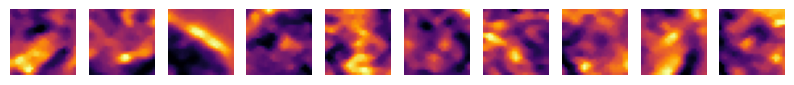

In [4]:
# generate images and plot a montage
size = 25
num_images = 10000
# channel = 'DPC_Right'
channel = 'DF_50'
channel = 'LED119'

images = create_images(size, 'led_array', num_images, channel=channel, median_filter=True, edge_crop=32)  
# images, cov_mat = create_images(size, 'stationary_GP', num_images, channel=channel, median_filter=True, edge_crop=32)  

# plot a montage of images
num_to_plot = 10
fig, ax = plt.subplots(1, num_to_plot, figsize=(num_to_plot, 1))
for i in range(num_to_plot):
    ax[i].imshow(images[i], cmap='inferno')
    ax[i].axis('off')

# TODO: replace conditional entropy calculation with samples from the stationary process?

0.0
conditional entropy clean:  2012.6414
conditional entropy noisy approx:  2007.8068
h_y_gaussian:  2122.958
Mutual information:  159.15329  bits
Mutual information:  0.2546453  bits per pixel


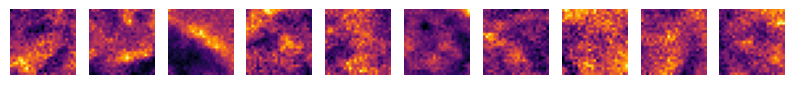

In [13]:
images_to_use = images * 0.1

if np.min(images_to_use) < 0:
    raise ValueError('images must be nonnegative')

noisy_images = np.array(add_shot_noise(images_to_use))
print(np.min(noisy_images)) 

h_y_given_x_true = compute_conditional_entropy(images_to_use)
h_y_given_x_noisy_approx = compute_conditional_entropy(noisy_images)

print('conditional entropy clean: ', h_y_given_x_true)
print('conditional entropy noisy approx: ', h_y_given_x_noisy_approx)


h_y_gaussian = gaussian_entropy_estimate(noisy_images, stationary=False, cutoff_percentile=8)

print('h_y_gaussian: ', h_y_gaussian)

mutual_info = (h_y_gaussian - h_y_given_x_true)
# convert from nats to bits
mutual_info /= np.log(2)

mutual_info_per_pixel = mutual_info / (images_to_use.shape[1] * images_to_use.shape[2])

print('Mutual information: ', mutual_info, ' bits')
print('Mutual information: ', mutual_info_per_pixel, ' bits per pixel')

# plot examples of noisy images
num_to_plot = 10
fig, ax = plt.subplots(1, num_to_plot, figsize=(num_to_plot, 1))
for i in range(num_to_plot):
    ax[i].imshow(noisy_images[i], cmap='inferno')
    ax[i].axis('off')
